# Pneumonia Detection From Chest X-Ray

## Inference on test data

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline

In [2]:
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import *
from keras.applications.vgg16 import VGG16
from keras.metrics import BinaryAccuracy
from keras.applications.vgg16 import preprocess_input

Using TensorFlow backend.


In [3]:
print(keras.__version__)

2.3.1


## Helper functions for inference

In [4]:
def check_dicom(filename): 
    """
    Load image pixel value array from dcm file
    Args:
        filename - (str) the file name of the dicom file
    Outputs:
        img - (ndarray) the 2D array of the image pixel values
    """

    print("Loading file {}".format(filename))
    dicom_data = pydicom.dcmread(filename)
    
    # "Modality" needs to be "DX"
    if dicom_data[0x0008, 0x0060].value != 'DX':
        print("[Warning] Not a valid dicom: Modality needs to be DX")
        return None
    
    # "Body Part Examined" needs to be "CHEST"
    if dicom_data[0x0018, 0x0015].value != "CHEST":
        print("[Warning] Not a valid dicom: Body Part Examined needs to be CHEST")
        return None
    
    # "Patient's Age" needs to be less than or equal to 100
    if int(dicom_data[0x0010, 0x1010].value) > 100:
        print("[Warning] Not a valid dicom: Age needs to be less than or equal to 100")
        return None
    
    # "Patient Position" needs to be "AP" or "PA"
    if dicom_data[0x0018, 0x5100].value not in ["AP", "PA"]:
        print("[Warning] Not a valid dicom: Patient Position needs to be AP or PA")
        return None
    
    # valid dicom
    print("Dicom is valid.")
    img = dicom_data.pixel_array
    return img
    
    
def preprocess_image(img, img_mean, img_std, img_size): 
    """
    Preprocess the image for the VGG model
    Args:
        img - (ndarray) the 2D array of the image pixel values
        img_mean - (float) the mean value for image standardization
        img_std - (float) the standard deviation dor image standardization
        img_size - (tuple) the final shape of the image tensor (n_batch, h, w, 3)
    Output:
        proc_img - (ndarray) the processed image with shape=img_size 
    """
    # final width (and height) of the image
    _, w, _, _ = img_size
    # image preprocessing
    img = np.fliplr(preprocess_input(img))
    # standardize image
    img = (img - img_mean)/img_std
    # reshape image
    img_gray = np.array(Image.fromarray(img).resize((w, w)))[None, ...]
    proc_img = np.concatenate((img_gray[..., None], img_gray[..., None], img_gray[..., None]), axis=3)    
    return proc_img


def load_model(model_path, weight_path):
    """
    Create the model and load weights from the workspace
    Args:
        model_path - the path where the model json file is stored
        weight_path - the path where the weights are stored
    Outputs:
        model - the keras model (VGG)
    """
    # create the model
    model = keras.Sequential(name='model')
    # load pretrained VGG16 (include_top=True)
    vgg16 = VGG16(include_top=True, weights='imagenet')
        # add all layers except for the last (dense) layer of vgg into model
    for vgg_layer in vgg16.layers[:-1]:
        #vgg_layer.trainable = False
        model.add(vgg_layer)
    # add a dropout layer and a final layer for binary classification
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    
    # optimizer
    opt = keras.optimizers.Adam(learning_rate=5e-5)
    # metrics
    metrics = [BinaryAccuracy(name='acc')]
    # compile
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=metrics)
    # load weights
    model.load_weights(weight_path)
    
    # sanity check: make sure the model is consistent with model_path
    model_json = model.to_json()
    # the json file stored at model_path
    path_json = open(model_path, 'r').read()
    # check
    assert model_json == path_json
    
    return model
    

def predict_image(model, img, thresh): 
    """
    Predict by the model
    Args:
        model - the keras model
        img - (ndarray) the processed test img. shape=(batch_size, 224, 224, 3)
        thresh - (float) the threshold above which means "With Pneumonia"
    Outputs:
        prediction - (str) the prediction of the model ("With Pneumonia" or "No Pneumonia")
    """
    score = model.predict(img)[0][0]
    
    if score > thresh:
        print("Score = {:.4f} (> threshold: {:.4f})".format(score, thresh))
        prediction = "With Pneumonia" 
    
    else:
        print("Score = {:.4f} (<= threshold: {:.4f})".format(score, thresh))
        prediction = "No Pneumonia" 
    
    return prediction 

## Inference

553467904/553467096 [==============================] - 6s 0us/step
Loading file test1.dcm
Dicom is valid.


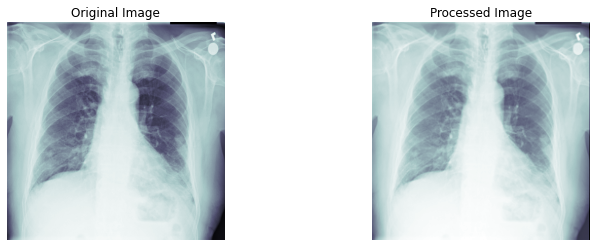

Score = 0.1794 (<= threshold: 0.2768)
Prediction: No Pneumonia



Loading file test2.dcm
Dicom is valid.


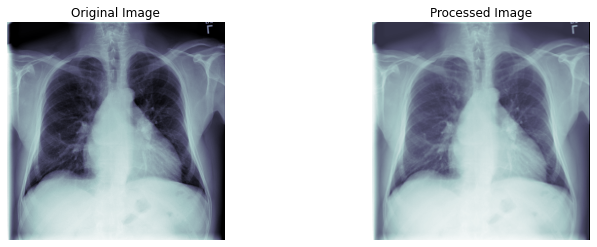

Score = 0.1143 (<= threshold: 0.2768)
Prediction: No Pneumonia



Loading file test3.dcm
Dicom is valid.


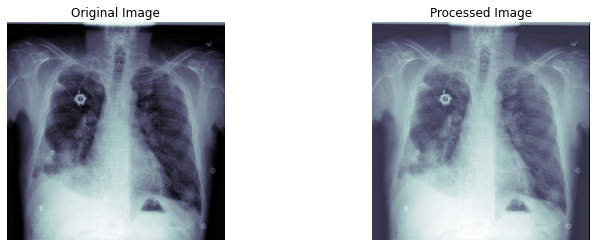

Score = 0.5861 (> threshold: 0.2768)
Prediction: With Pneumonia



Loading file test4.dcm
[Warning] Not a valid dicom: Body Part Examined needs to be CHEST
Loading file test5.dcm
[Warning] Not a valid dicom: Modality needs to be DX
Loading file test6.dcm
[Warning] Not a valid dicom: Patient Position needs to be AP or PA


In [5]:
test_dicoms = ['test1.dcm','test2.dcm','test3.dcm','test4.dcm','test5.dcm','test6.dcm']

model_path = "./my_model.json"
weight_path = "./xray_class_my_model.best.hdf5"

IMG_SIZE = (1, 224, 224, 3)
img_mean = 127.5
img_std = 127.5

my_model = load_model(model_path, weight_path)
thresh = 0.2768

for i in test_dicoms:
    print("============================================")
    img = np.array([])
    img = check_dicom(i)

    if img is None:
        continue
        
    img_proc = preprocess_image(img, img_mean, img_std, IMG_SIZE)
    
    # display the image
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.imshow(img, cmap = 'bone')
    ax2.imshow(img_proc[0,:,:,0], cmap = 'bone')
    ax1.set_title("Original Image")
    ax2.set_title("Processed Image")
    ax1.axis('off')
    ax2.axis('off')
    plt.show()

    pred = predict_image(my_model, img_proc, thresh)
    
    print("Prediction: {}".format(pred))
    print("============================================")
    print("\n\n")

In [6]:
dicom_data = pydicom.dcmread('test1.dcm')
dicom_data

(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.11129.5.5.110503645592756492463169821050252582267888
(0008, 0060) Modality                            CS: 'DX'
(0008, 1030) Study Description                   LO: 'No Finding'
(0010, 0020) Patient ID                          LO: '2'
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's Age                       AS: '81'
(0018, 0015) Body Part Examined                  CS: 'CHEST'
(0018, 5100) Patient Position                    CS: 'PA'
(0020, 000d) Study Instance UID                  UI: 1.3.6.1.4.1.11129.5.5.112507010803284478207522016832191866964708
(0020, 000e) Series Instance UID                 UI: 1.3.6.1.4.1.11129.5.5.112630850362182468372440828755218293352329
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows       

In [7]:
dicom_data = pydicom.dcmread('test2.dcm')
dicom_data

(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.11129.5.5.153751009835107614666834563294684339746480
(0008, 0060) Modality                            CS: 'DX'
(0008, 1030) Study Description                   LO: 'Cardiomegaly'
(0010, 0020) Patient ID                          LO: '1'
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's Age                       AS: '58'
(0018, 0015) Body Part Examined                  CS: 'CHEST'
(0018, 5100) Patient Position                    CS: 'AP'
(0020, 000d) Study Instance UID                  UI: 1.3.6.1.4.1.11129.5.5.111396399361969898205364400549799252857604
(0020, 000e) Series Instance UID                 UI: 1.3.6.1.4.1.11129.5.5.195628213694300498946760767481291263511724
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows     

In [8]:
dicom_data = pydicom.dcmread('test3.dcm')
dicom_data

(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.11129.5.5.179222148351666120521423991179194552820263
(0008, 0060) Modality                            CS: 'DX'
(0008, 1030) Study Description                   LO: 'Effusion'
(0010, 0020) Patient ID                          LO: '61'
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's Age                       AS: '77'
(0018, 0015) Body Part Examined                  CS: 'CHEST'
(0018, 5100) Patient Position                    CS: 'AP'
(0020, 000d) Study Instance UID                  UI: 1.3.6.1.4.1.11129.5.5.189886800072183603320722059194952488628637
(0020, 000e) Series Instance UID                 UI: 1.3.6.1.4.1.11129.5.5.110145974268321300517474523922373370343198
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows        

In [9]:
dicom_data = pydicom.dcmread('test4.dcm')
dicom_data

(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.11129.5.5.110503645592756492463169821050252582267888
(0008, 0060) Modality                            CS: 'DX'
(0008, 1030) Study Description                   LO: 'No Finding'
(0010, 0020) Patient ID                          LO: '2'
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's Age                       AS: '81'
(0018, 0015) Body Part Examined                  CS: 'RIBCAGE'
(0018, 5100) Patient Position                    CS: 'PA'
(0020, 000d) Study Instance UID                  UI: 1.3.6.1.4.1.11129.5.5.112507010803284478207522016832191866964708
(0020, 000e) Series Instance UID                 UI: 1.3.6.1.4.1.11129.5.5.112630850362182468372440828755218293352329
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows     

In [10]:
dicom_data = pydicom.dcmread('test5.dcm')
dicom_data

(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.11129.5.5.110503645592756492463169821050252582267888
(0008, 0060) Modality                            CS: 'CT'
(0008, 1030) Study Description                   LO: 'No Finding'
(0010, 0020) Patient ID                          LO: '2'
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's Age                       AS: '81'
(0018, 0015) Body Part Examined                  CS: 'CHEST'
(0018, 5100) Patient Position                    CS: 'PA'
(0020, 000d) Study Instance UID                  UI: 1.3.6.1.4.1.11129.5.5.112507010803284478207522016832191866964708
(0020, 000e) Series Instance UID                 UI: 1.3.6.1.4.1.11129.5.5.112630850362182468372440828755218293352329
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows       

In [11]:
dicom_data = pydicom.dcmread('test6.dcm')
dicom_data

(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.11129.5.5.110503645592756492463169821050252582267888
(0008, 0060) Modality                            CS: 'DX'
(0008, 1030) Study Description                   LO: 'No Finding'
(0010, 0020) Patient ID                          LO: '2'
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's Age                       AS: '81'
(0018, 0015) Body Part Examined                  CS: 'CHEST'
(0018, 5100) Patient Position                    CS: 'XX'
(0020, 000d) Study Instance UID                  UI: 1.3.6.1.4.1.11129.5.5.112507010803284478207522016832191866964708
(0020, 000e) Series Instance UID                 UI: 1.3.6.1.4.1.11129.5.5.112630850362182468372440828755218293352329
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows       